# Using Regression models for rental apartments in Kuftsein Austria

We used Web Scraping methods to get infos about rental apartments in Kufstein from Immoscout24.at and saved our results to the dataframe below.<br>
Now we are going to use Regression models to fit and predict our model

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("immoscout_regression.csv").drop(["Unnamed: 0"],axis=1)

### Gather basic infos about the Dataframe

In [3]:
df.head()

,title,num_rooms,area,availability,build_year,parking,elevator,price,sqft_price,heating_type
0,Moderne Terrassenwohnung mit Blick auf den Wil...,5.0,143.0,Wohnfläche 143 m²,1 TerrasseTerrasse,NaN,NaN,2500.0,"17,48",NaN
1,Bezaubernde Wohnung am Kraftplatz Hintersteine...,2.0,136.0,"Baujahr 2007Neuwertig, Dielen, Fliesen",Wohnfläche 136 m²,"Einbauküche, Badewanne, Dusche, Kamin",NaN,2150.0,"15,81",Fußbodenheizung
2,Dreizimmerwohnung mit Kaiserblick,3.0,89.0,Verfügbar ab Nach Vereinbarung.....,"Baujahr 1995Gepflegt, Unterkellert, Parkett",Tiefgarage1 Parkmöglichkeit,NaN,1070.0,"12,02",Zentralheizung
3,ANGERBERG - Signature Designerwohnung mit Loft...,4.0,130.0,Verfügbar ab ab sofort,Parkett,Carport2 Parkmöglichkeiten,NaN,NaN,NaN,Öl
4,"Wunderschöne, ruhig gelegene 4-Zimmer Wohnung ...",4.0,88.0,Verfügbar ab sofort,"Baujahr 2009Neubau, Neuwertig, Unterkellert, P...",Tiefgarage2 Parkmöglichkeiten,NaN,1450.0,"16,48",Zentralheizung


In [4]:
df.shape

(135, 10)

In [5]:
df.isnull().sum()

title            0
num_rooms        1
area             4
availability     0
build_year       1
parking         26
elevator        99
price           23
sqft_price      23
heating_type    34
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         135 non-null    object 
 1   num_rooms     134 non-null    float64
 2   area          131 non-null    float64
 3   availability  135 non-null    object 
 4   build_year    134 non-null    object 
 5   parking       109 non-null    object 
 6   elevator      36 non-null     object 
 7   price         112 non-null    float64
 8   sqft_price    112 non-null    object 
 9   heating_type  101 non-null    object 
dtypes: float64(3), object(7)
memory usage: 10.7+ KB


### Data Processing - fill missing values and prepare data for model

Unfortunately I noticed, that the Immoscout page has not every info in the same column (for example there are some examples where in the room column the value for area is written..) or some missing values. So I had to reprocess the data and look from the df['features'] from the Scraper model to find out the missing values.<br>
I know it is a little confusing and not the best method but this is how I tried to solve it.

**Refine the 'num_rooms' column**

In [7]:
df['num_rooms']=df['num_rooms'].fillna(df['num_rooms'].mean()).astype(int)
df['num_rooms'].value_counts()

2     54
3     49
4     19
1      7
5      3
70     1
68     1
66     1
Name: num_rooms, dtype: int64

Since there is no logic in room numbers up to 70, this has to be the area, which was in the wrong column.<br>
So we have to find where the wrong values are located and change them

In [8]:
# Find the index of the wrong values
df.index[df['num_rooms']==1].tolist()
df.index[df['num_rooms']==70].tolist()
df.index[df['num_rooms']==68].tolist()
df.index[df['num_rooms']==66].tolist()

[79]

In [9]:
# replace wrong values in specific index with right value
df["area"][16]=70
df['num_rooms'][16]=2 #replace with mostly occuring value 
df["area"][39]=68
df['num_rooms'][39]=2 #replace with value from df['features'] from Scraper model
df["area"][79]=66
df['num_rooms'][79]=2 #replace with mostly occuring value 

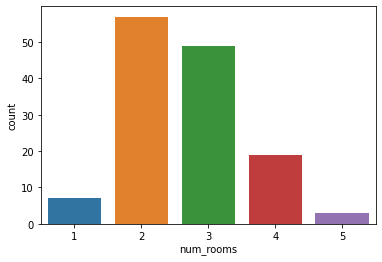

In [10]:
sns.countplot(x=df['num_rooms']);

**Refine the 'area' column**

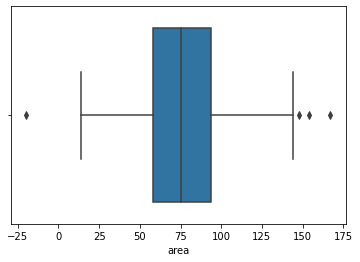

In [11]:
sns.boxplot(x=df['area']);

In [12]:
df.index[df['area']<0].tolist() #find the index of where the area is minus value and replace with mean value

[109]

In [13]:
df['area'].mean()

79.07462686567165

In [14]:
df['area']=df['area'].fillna(df['area'].mean()) #replace missing values and wrong values with mean value
df['area'][109]=79.81 #if I tried fillna() here I got an error so I did it the old way round

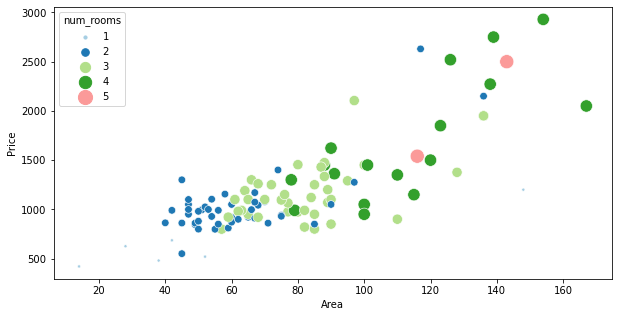

In [15]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(x=df.area, y=df.price, hue=df.num_rooms, size=df.num_rooms, palette='Paired', sizes=(10, 200))
plt.xlabel("Area"), plt.ylabel("Price"), plt.show();

**Refine the 'availability' column**

In [16]:
df['availability'].value_counts()

Verfügbar ab sofort                  22
Verfügbar ab ab sofort               10
Verfügbar ab nach Vereinbarung        9
Verfügbar ab 01.01.2023               6
Verfügbar ab 01.12.2022               5
                                     ..
Verfügbar ab 2023-03-01               1
Verfügbar ab 01. Februar 2023         1
Verfügbar ab Anfang Dezember 2022     1
Verfügbar ab September 2022           1
Grundstück voll erschlossen           1
Name: availability, Length: 70, dtype: int64

In [17]:
# Here we see that the dataframe is very mixed we delete this column
for i in df['availability']:
    if i.startswith('Verfügbar ab') is False:
        print(i)

Wohnfläche 143 m²
Baujahr 2007Neuwertig, Dielen, Fliesen
Gesamtfläche 87 m²
Wohnfläche 70 m²
Unterkellert
Terrasse
Gepflegt
Baujahr 2007Gepflegt
Wohnfläche 136 m²
Wohnfläche 110 m²
Wohnfläche 138 m²
NeubauGepflegt, Massivbauweise, Holzbauweise, Grundstück voll erschlossen, Laminat, Parkett, Fliesen
NeuwertigDielen, Fliesen
Wohnfläche 78 m²
Unterkellert
NeubauNeuwertig, Unterkellert
Wohnfläche 90 m²
AltbauGepflegt
Baujahr 2019Neubau, Neuwertig, Unterkellert
Baujahr 2008Altbau, Neuwertig
Grundstück voll erschlossen


In [18]:
for i in range(0,len(df['availability'])):
    df['availability'][i]=re.findall(r'\d+', df['availability'][i]) #extract numbers from string

In [19]:
# We can see that almost half of the values are empty
df.availability.value_counts()

[]                68
[2022]            10
[01, 01, 2023]     8
[2023]             7
[01, 12, 2022]     5
[01, 02, 2023]     4
[01, 11, 2022]     3
[2007]             2
[01, 2023]         2
[1, 2023]          2
[02, 2023]         2
[2022, 09, 19]     1
[2022, 11, 18]     1
[1, 11, 2022]      1
[143]              1
[01, 2022]         1
[05, 12, 22]       1
[1, 2, 2022]       1
[90]               1
[2019]             1
[78]               1
[1, 23]            1
[138]              1
[2023, 03, 01]     1
[110]              1
[136]              1
[01, 05, 2022]     1
[1, 2, 2023]       1
[01, 02, 23]       1
[01, 04, 2021]     1
[70]               1
[87]               1
[2008]             1
Name: availability, dtype: int64

Almost half of our values are empty (68), so we don't know about the availability and the values are also very mixed. So we delete this column

In [20]:
df.drop('availability', axis=1, inplace=True)

**Refine the 'build_year' column**

In [21]:
df['build_year'].fillna('unnknown', inplace=True) # fill empty value with 'unnknown'

In [22]:
for i in range(0,len(df['build_year'])):
    df['build_year'][i]=re.findall(r'\d+', df['build_year'][i]) #extract numbers from string

In [23]:
dfb = pd.DataFrame(df['build_year'].to_list(), columns=['bldyr1','bldyr2','bldyr3']) # list the values as three columns
dfb=dfb.fillna(0) # fill empty values with 0 (to be able to change to int type)
dfb=dfb.astype(int)
dfb.where(dfb > 1900, inplace=True) # only take values above 1900 (mixed values, some values where for example 80 for area)
dfb=dfb.fillna(0)
dfb=dfb.astype(int)
dfb['bldyr1'].replace(0,2022,inplace=True) #fill unknown values with mode value
df['build_year']=dfb['bldyr1']

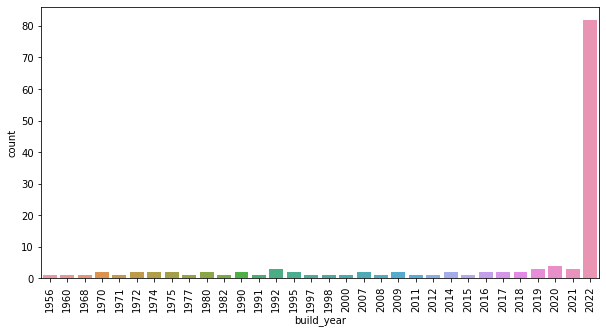

In [24]:
plt.figure(figsize=(10,5))
sns.countplot(x=df['build_year']);
plt.xticks(rotation=90);

Make a new 'age' column and delete the build year column

In [25]:
# Feature Engineering
df['age']=2022-df['build_year']
df.drop('build_year', axis=1, inplace=True)

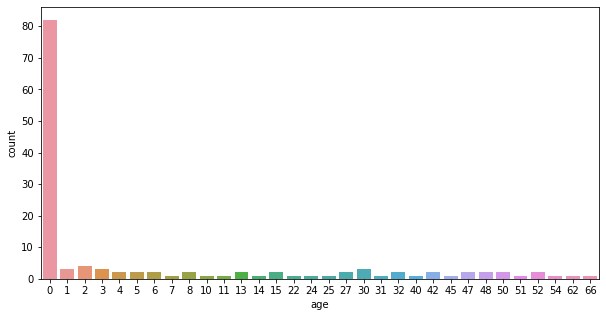

In [26]:
plt.figure(figsize=(10,5))
sns.countplot(x=df['age']);

**Refine the 'parking' column**

In [27]:
df['parking'].fillna('unnknown', inplace=True) # fill empty values

In [28]:
for i in range(0,len(df['parking'])):
    df['parking'][i]=re.findall(r'\d+', df['parking'][i]) #extract numbers from string

In [29]:
dfp = pd.DataFrame(df['parking'].to_list(), columns=['p1','p2','p3']) # list in 3 columns
dfp['p1'].replace(np.nan, 0,inplace=True) # replace None values with 0 (0 parking lots)
df['parking']=dfp['p1']
df['parking']=df['parking'].astype(int)

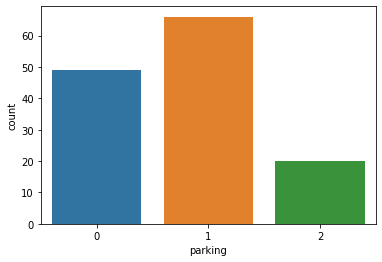

In [30]:
sns.countplot(x=df['parking']); #most of the apartments have 1 parking lot, then none and some have 2 parking lots

**Refine the 'elevator' column**

In [31]:
df['elevator'].replace(np.nan, "no", inplace=True) # fill empty values
df.elevator = df.elevator.apply(lambda x: 'yes' if 'Personenaufzug' in x else x) # if "Personenaufzug" is in the string replace with 'yes'
df.elevator=df.elevator.map({"no":0,"Barrierefrei":0,"Rollstuhlgerecht":0,"yes":1}) # replace yes with 1 (elevator is available) and rest to 0 (not available)

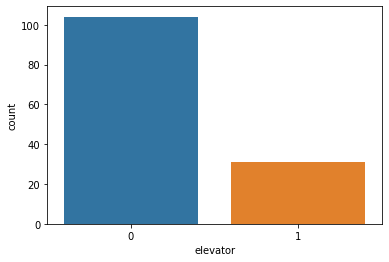

In [32]:
sns.countplot(x=df['elevator']);

**Refine the 'price' column**

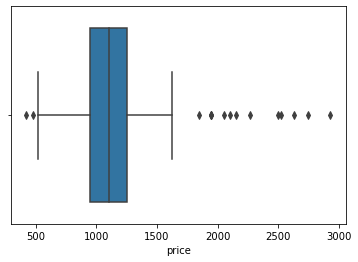

In [33]:
df.price.fillna(df.price.mean(), inplace=True) # replace missing values with mean value
sns.boxplot(x=df['price']);

**Refine the 'sqft_price' column**

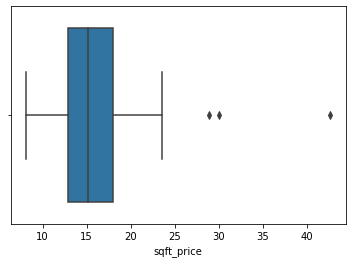

In [34]:
df['sqft_price']=df['sqft_price'].str.replace(',','.').astype(float) # replace , with .
df['sqft_price']=df['price']/df['area'] # redo the math to fill empty values of this column
sns.boxplot(x=df['sqft_price']);

In [35]:
df.head()

,title,num_rooms,area,parking,elevator,price,sqft_price,heating_type,age
0,Moderne Terrassenwohnung mit Blick auf den Wil...,5,143.0,0,0,2500.000000,17.482517,NaN,0
1,Bezaubernde Wohnung am Kraftplatz Hintersteine...,2,136.0,0,0,2150.000000,15.808824,Fußbodenheizung,0
2,Dreizimmerwohnung mit Kaiserblick,3,89.0,1,0,1070.000000,12.022472,Zentralheizung,27
3,ANGERBERG - Signature Designerwohnung mit Loft...,4,130.0,2,0,1195.267857,9.194368,Öl,0
4,"Wunderschöne, ruhig gelegene 4-Zimmer Wohnung ...",4,88.0,2,0,1450.000000,16.477273,Zentralheizung,13


**Refine the 'heating_type' column**

In [36]:
df.heating_type.replace(np.nan, "Zentralheizung", inplace=True) # fill empty values with mode
df.heating_type.replace("Heizwärmebedarf", "Zentralheizung", inplace=True) # replace "HWB" with mode

In [37]:
df.heating_type.value_counts()

Zentralheizung     93
Fußbodenheizung    22
Fernwärme           6
Ofenheizung         5
Etagenheizung       3
Öl                  2
Pellet              2
Gas                 1
Elektro             1
Name: heating_type, dtype: int64

**DataFrame after Reprocessing the data**

In [38]:
df.sample(5)

,title,num_rooms,area,parking,elevator,price,sqft_price,heating_type,age
32,"sonnige 3,5-Zimmer-Wohnung in Ebbs mit Bergbli...",3,82.0,2,0,820.000000,10.000000,Zentralheizung,32
48,Brixlegg: große 4-Zimmerwohnung in idyllischer...,4,100.0,0,0,1050.000000,10.500000,Zentralheizung,0
7,Schöne 3 Zimmer Wohnung,3,87.0,0,0,1195.267857,13.738711,Zentralheizung,0
130,3-Zimmer Wohnung im 3. OG,3,59.0,0,0,921.000000,15.610169,Zentralheizung,0
36,Zentrale 2-Zimmer Mietwohnung in Kufstein,2,54.0,0,0,928.000000,17.185185,Zentralheizung,0


In [39]:
df.isnull().sum()

title           0
num_rooms       0
area            0
parking         0
elevator        0
price           0
sqft_price      0
heating_type    0
age             0
dtype: int64

### EDA 

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         135 non-null    object 
 1   num_rooms     135 non-null    int32  
 2   area          135 non-null    float64
 3   parking       135 non-null    int32  
 4   elevator      135 non-null    int64  
 5   price         135 non-null    float64
 6   sqft_price    135 non-null    float64
 7   heating_type  135 non-null    object 
 8   age           135 non-null    int32  
dtypes: float64(3), int32(3), int64(1), object(2)
memory usage: 8.0+ KB


In [41]:
df.shape

(135, 9)

In [42]:
df.describe()

,num_rooms,area,parking,elevator,price,sqft_price,age
count,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000
mean,2.659259,79.813960,0.785185,0.229630,1195.267857,15.795404,9.407407
std,0.865275,29.431456,0.684424,0.422161,425.945673,4.561406,17.014172
min,1.000000,14.000000,0.000000,0.000000,420.000000,8.108108,0.000000
25%,2.000000,59.000000,0.000000,0.000000,950.000000,12.903334,0.000000
50%,3.000000,75.000000,1.000000,0.000000,1103.000000,15.115694,0.000000
75%,3.000000,93.000000,1.000000,0.000000,1255.000000,18.027505,9.000000
max,5.000000,167.000000,2.000000,1.000000,2930.000000,42.688138,66.000000


In [43]:
abs(df.corr()['price']).sort_values(ascending=False)

price         1.000000
area          0.730676
num_rooms     0.501410
parking       0.144855
sqft_price    0.132740
age           0.114397
elevator      0.050105
Name: price, dtype: float64

<AxesSubplot:>

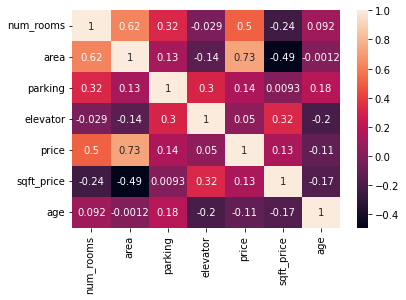

In [44]:
sns.heatmap(df.corr(),annot=True)

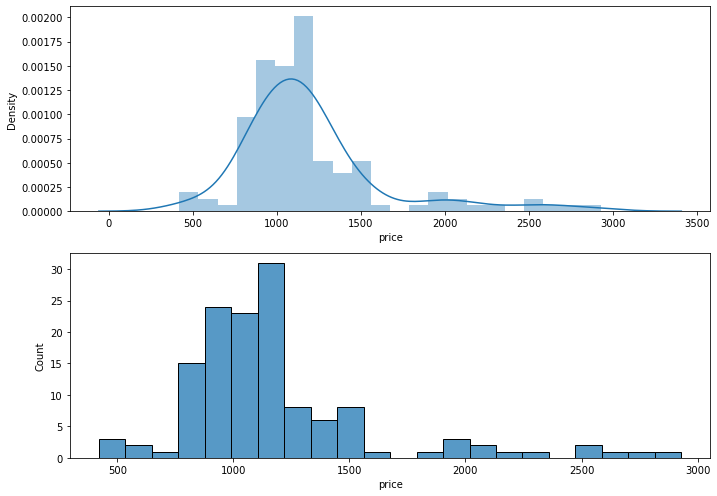

In [45]:
fig = plt.figure(figsize=(10,7))
fig.add_subplot(2,1,1)
sns.distplot(df['price'])
fig.add_subplot(2,1,2)
sns.histplot(df['price'])
plt.tight_layout();

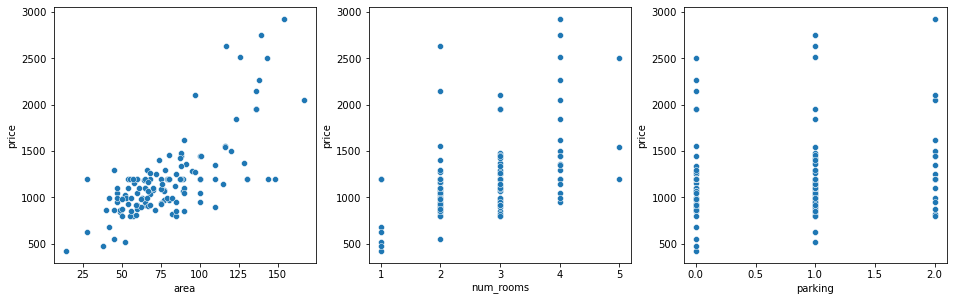

In [46]:
fig = plt.figure(figsize=(16,16))
fig.add_subplot(3,3,1)
sns.scatterplot(df['area'], df['price'])
fig.add_subplot(3,3,2)
sns.scatterplot(df['num_rooms'],df['price'])
fig.add_subplot(3,3,3)
sns.scatterplot(df['parking'],df['price']);

## Regression to predict rent prices

In [47]:
# define x and y
x,y=df.drop(["price","title","sqft_price"],axis=1),df[["price"]] 
x=pd.get_dummies(x,drop_first=True)

In [48]:
def regression_funct(x,y):
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Ridge,Lasso
    from sklearn.linear_model import ElasticNet
    from sklearn.tree import ExtraTreeRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.neighbors import KNeighborsRegressor
    
    from sklearn.model_selection import train_test_split

    from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
    
    
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

    L=LinearRegression()
    R=Ridge()
    Lass=Lasso()
    E=ElasticNet()
    ExTree=ExtraTreeRegressor()
    GBR=GradientBoostingRegressor()
    KN=KNeighborsRegressor()
    
    algos=[L,R,Lass,E,ExTree,GBR,KN]
    algo_names=['LinearRegression','Ridge','Lasso','ElasticNet','ExtraTreeRegressor','GradientBoostingRegressor','KNeighborsRegressor']
    r_squared=[]
    rmse=[]
    mae=[]
    
    result=pd.DataFrame(columns=['R_Squared','RMSE','MAE'],index=algo_names)
    
    for item in algos:
        item.fit(x_train,y_train)
        item.predict(x_test)
        r_squared.append(r2_score(y_test,item.predict(x_test)))
        rmse.append((mean_squared_error(y_test,item.predict(x_test)))**.5)
        mae.append(mean_absolute_error(y_test,item.predict(x_test)))
        
    result.R_Squared=r_squared
    result.RMSE=rmse
    result.MAE=mae
        
    return result.sort_values('R_Squared',ascending=False)

In [49]:
regression_funct(x,y)

,R_Squared,RMSE,MAE
ElasticNet,0.477895,372.733075,255.871061
Ridge,0.353628,414.724983,274.459874
KNeighborsRegressor,0.350575,415.703318,262.874603
Lasso,0.313320,427.460538,280.687044
LinearRegression,0.263902,442.574658,286.410751
GradientBoostingRegressor,0.226149,453.782234,283.417471
ExtraTreeRegressor,-0.025851,522.469601,385.798611


## Deep learning

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import  r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [51]:
x=scaler.fit_transform(x)

In [52]:
pd.DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.00,0.843137,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.25,0.797386,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.50,0.490196,0.5,0.0,0.409091,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.75,0.758170,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.75,0.483660,1.0,0.0,0.196970,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.50,0.294118,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
131,0.50,0.405229,0.5,1.0,0.121212,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
132,0.75,0.660131,0.5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133,0.25,0.281046,0.5,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
x.shape,y.shape

((135, 13), (135, 1))

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=42)

In [55]:
model=Sequential()
model.add(Dense(440, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(380, activation='relu'))
model.add(Dense(340, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(220, activation='relu'))
model.add(Dense(198, activation='relu'))
model.add(Dense(180, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(70, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam', loss='mse')#mse regression

In [56]:
model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=128, epochs=500, verbose=1)

Epoch 1/500
1/1 [==============================] - 1s 972ms/step - loss: 1469479.1250 - val_loss: 2165788.5000
Epoch 2/500
1/1 [==============================] - 0s 16ms/step - loss: 1469446.6250 - val_loss: 2165678.2500
Epoch 3/500
1/1 [==============================] - 0s 16ms/step - loss: 1469358.2500 - val_loss: 2165382.2500
Epoch 4/500
1/1 [==============================] - 0s 31ms/step - loss: 1469122.1250 - val_loss: 2164731.0000
Epoch 5/500
1/1 [==============================] - 0s 19ms/step - loss: 1468604.5000 - val_loss: 2163240.0000
Epoch 6/500
1/1 [==============================] - 0s 13ms/step - loss: 1467420.0000 - val_loss: 2160011.2500
Epoch 7/500
1/1 [==============================] - 0s 16ms/step - loss: 1464857.1250 - val_loss: 2153417.5000
Epoch 8/500
1/1 [==============================] - 0s 16ms/step - loss: 1459629.6250 - val_loss: 2140010.2500
Epoch 9/500
1/1 [==============================] - 0s 16ms/step - loss: 1449002.1250 - val_loss: 2113159.7500
Epoch 10/

1/1 [==============================] - 0s 29ms/step - loss: 51416.3828 - val_loss: 210555.7812
Epoch 77/500
1/1 [==============================] - 0s 16ms/step - loss: 51614.3438 - val_loss: 211230.9375
Epoch 78/500
1/1 [==============================] - 0s 16ms/step - loss: 51102.3281 - val_loss: 214473.6406
Epoch 79/500
1/1 [==============================] - 0s 31ms/step - loss: 50288.2031 - val_loss: 219015.6094
Epoch 80/500
1/1 [==============================] - 0s 16ms/step - loss: 50019.2969 - val_loss: 222382.0156
Epoch 81/500
1/1 [==============================] - 0s 16ms/step - loss: 50108.6484 - val_loss: 222553.5156
Epoch 82/500
1/1 [==============================] - 0s 16ms/step - loss: 49850.4219 - val_loss: 219780.3281
Epoch 83/500
1/1 [==============================] - 0s 16ms/step - loss: 49242.4180 - val_loss: 216153.1719
Epoch 84/500
1/1 [==============================] - 0s 32ms/step - loss: 48862.2930 - val_loss: 213735.4062
Epoch 85/500
1/1 [=======================

1/1 [==============================] - 0s 16ms/step - loss: 36225.8594 - val_loss: 220113.6719
Epoch 152/500
1/1 [==============================] - 0s 16ms/step - loss: 36063.9805 - val_loss: 220037.6406
Epoch 153/500
1/1 [==============================] - 0s 31ms/step - loss: 35907.6719 - val_loss: 219971.3125
Epoch 154/500
1/1 [==============================] - 0s 16ms/step - loss: 35741.3906 - val_loss: 219942.7031
Epoch 155/500
1/1 [==============================] - 0s 16ms/step - loss: 35576.7031 - val_loss: 219841.4688
Epoch 156/500
1/1 [==============================] - 0s 16ms/step - loss: 35422.1836 - val_loss: 219655.0156
Epoch 157/500
1/1 [==============================] - 0s 31ms/step - loss: 35265.4062 - val_loss: 219592.4219
Epoch 158/500
1/1 [==============================] - 0s 16ms/step - loss: 35111.4336 - val_loss: 219740.2188
Epoch 159/500
1/1 [==============================] - 0s 18ms/step - loss: 34950.3086 - val_loss: 220030.2031
Epoch 160/500
1/1 [==============

1/1 [==============================] - 0s 31ms/step - loss: 24605.9277 - val_loss: 225824.6406
Epoch 227/500
1/1 [==============================] - 0s 16ms/step - loss: 24443.7656 - val_loss: 226095.5938
Epoch 228/500
1/1 [==============================] - 0s 16ms/step - loss: 24289.0332 - val_loss: 226098.4688
Epoch 229/500
1/1 [==============================] - 0s 31ms/step - loss: 24127.8340 - val_loss: 225732.7969
Epoch 230/500
1/1 [==============================] - 0s 16ms/step - loss: 23963.7754 - val_loss: 225332.7031
Epoch 231/500
1/1 [==============================] - 0s 32ms/step - loss: 23808.8516 - val_loss: 225524.6719
Epoch 232/500
1/1 [==============================] - 0s 16ms/step - loss: 23655.3145 - val_loss: 226279.3125
Epoch 233/500
1/1 [==============================] - 0s 16ms/step - loss: 23485.3516 - val_loss: 226999.2188
Epoch 234/500
1/1 [==============================] - 0s 31ms/step - loss: 23323.4297 - val_loss: 226960.8594
Epoch 235/500
1/1 [==============

1/1 [==============================] - 0s 32ms/step - loss: 14120.6924 - val_loss: 227221.3906
Epoch 302/500
1/1 [==============================] - 0s 16ms/step - loss: 14042.7480 - val_loss: 227668.2969
Epoch 303/500
1/1 [==============================] - 0s 16ms/step - loss: 13951.2021 - val_loss: 228729.0781
Epoch 304/500
1/1 [==============================] - 0s 16ms/step - loss: 13865.9502 - val_loss: 228475.9375
Epoch 305/500
1/1 [==============================] - 0s 16ms/step - loss: 13812.8984 - val_loss: 227977.5781
Epoch 306/500
1/1 [==============================] - 0s 18ms/step - loss: 13727.7373 - val_loss: 226278.0781
Epoch 307/500
1/1 [==============================] - 0s 14ms/step - loss: 13650.2627 - val_loss: 226317.7969
Epoch 308/500
1/1 [==============================] - 0s 31ms/step - loss: 13584.7617 - val_loss: 228054.2812
Epoch 309/500
1/1 [==============================] - 0s 16ms/step - loss: 13519.8955 - val_loss: 228084.7656
Epoch 310/500
1/1 [==============

1/1 [==============================] - 0s 16ms/step - loss: 10988.3916 - val_loss: 225556.7344
Epoch 377/500
1/1 [==============================] - 0s 16ms/step - loss: 10949.2686 - val_loss: 222237.1250
Epoch 378/500
1/1 [==============================] - 0s 16ms/step - loss: 10772.2705 - val_loss: 222749.8906
Epoch 379/500
1/1 [==============================] - 0s 16ms/step - loss: 10718.8125 - val_loss: 225611.9219
Epoch 380/500
1/1 [==============================] - 0s 16ms/step - loss: 10792.8330 - val_loss: 221733.3281
Epoch 381/500
1/1 [==============================] - 0s 16ms/step - loss: 10873.6836 - val_loss: 225010.7344
Epoch 382/500
1/1 [==============================] - 0s 31ms/step - loss: 10805.7773 - val_loss: 220834.2188
Epoch 383/500
1/1 [==============================] - 0s 16ms/step - loss: 10649.5459 - val_loss: 221358.0156
Epoch 384/500
1/1 [==============================] - 0s 16ms/step - loss: 10611.6367 - val_loss: 223846.5625
Epoch 385/500
1/1 [==============

1/1 [==============================] - 0s 16ms/step - loss: 9178.0107 - val_loss: 219297.9688
Epoch 452/500
1/1 [==============================] - 0s 16ms/step - loss: 9118.5303 - val_loss: 220472.0156
Epoch 453/500
1/1 [==============================] - 0s 16ms/step - loss: 9136.0381 - val_loss: 217979.7656
Epoch 454/500
1/1 [==============================] - 0s 21ms/step - loss: 9202.5176 - val_loss: 223570.8750
Epoch 455/500
1/1 [==============================] - 0s 26ms/step - loss: 9328.6777 - val_loss: 217296.4844
Epoch 456/500
1/1 [==============================] - 0s 16ms/step - loss: 9401.9883 - val_loss: 224616.7188
Epoch 457/500
1/1 [==============================] - 0s 31ms/step - loss: 9402.6729 - val_loss: 217981.0938
Epoch 458/500
1/1 [==============================] - 0s 16ms/step - loss: 9255.5576 - val_loss: 222588.7969
Epoch 459/500
1/1 [==============================] - 0s 16ms/step - loss: 9083.5869 - val_loss: 220352.4688
Epoch 460/500
1/1 [=======================

In [57]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 440)               6160      
                                                                 
 dense_1 (Dense)             (None, 400)               176400    
                                                                 
 dense_2 (Dense)             (None, 380)               152380    
                                                                 
 dense_3 (Dense)             (None, 340)               129540    
                                                                 
 dense_4 (Dense)             (None, 300)               102300    
                                                                 
 dense_5 (Dense)             (None, 250)               75250     
                                                                 
 dense_6 (Dense)             (None, 220)               5

<AxesSubplot:>

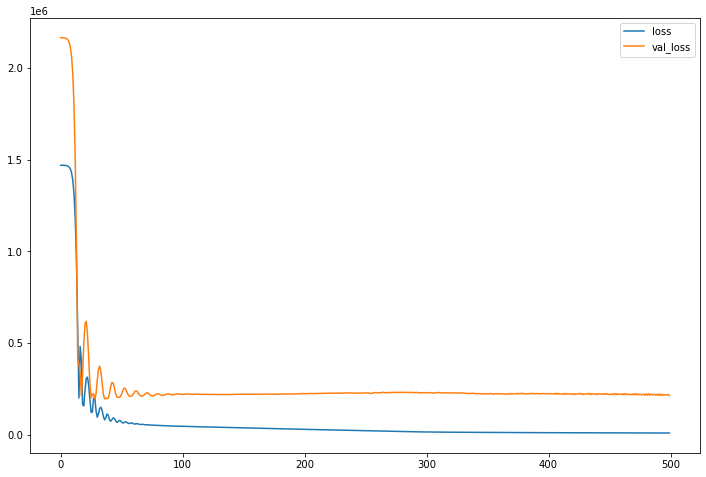

In [58]:
loss_df=pd.DataFrame(model.history.history)
loss_df.plot(figsize=(12,8))

In [59]:
pred=model.predict(x_test)

1/1 [==============================] - 0s 109ms/step


In [60]:
(mean_squared_error(y_test,pred))**.5

461.01861936916254

In [61]:
r2_score(y_test,pred)

0.20127132871708375

The results are not great, but I had really problem dealing with the values given of the scraper.

## Using WordCloud to see mostly occuring words in the title

In [62]:
# Text processing
df["title"]=df["title"].str.lower() # change to lower case
df["title"]=df["title"].str.replace('[^\w\s]','') # get rid of punctuation
df["title"]=df["title"].str.replace('\d+','') # get rid of digits
df["title"]=df["title"].str.replace('\n',' ').replace('\r',' ') # get rid of enter and returns

In [77]:
from wordcloud import WordCloud

def wc(data,bgcolor):
    from PIL import Image
    mask = np.array(Image.open("cloud.png"))
    wc=WordCloud(background_color=bgcolor, width=800, height=400,mask=mask,max_words=100).generate(' '.join(data))
    plt.figure( figsize=(20,10) )
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

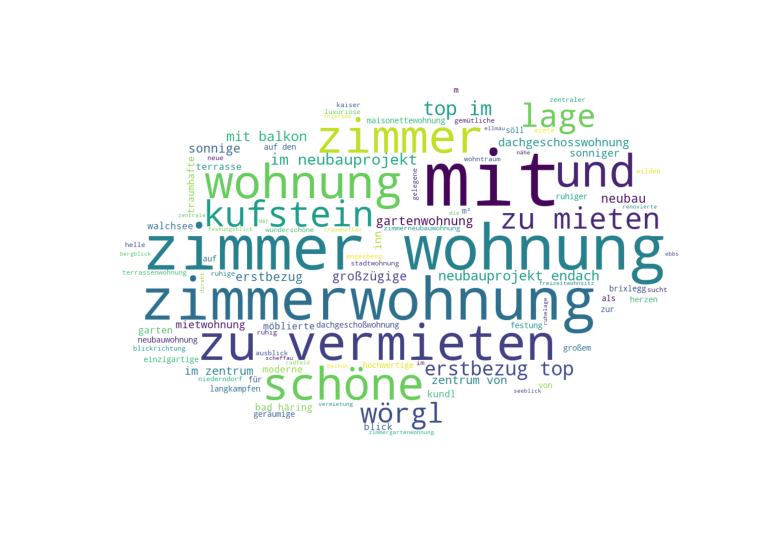

In [78]:
wc(df.title,'white')